# Persistance Benchmark Model
The basic version of this benchmark model uses the load from 24 hours prior to predict the load at any given day/time.
There is an ability to account for whether or not the date/time to be predicted is a workday (weekday and not holiday) 
or not, and get the load from the most recent day that has the same workday status to use as the prediction.

Author: Riley Denn

In [1]:
import pandas as pd
import numpy as np
import json
import os
import random
from sklearn.model_selection import train_test_split
import typing as t
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('../../config.json', 'r') as config_file:
    config = json.load(config_file)

DRIVE_PATH = config['drive_path']
EXTERNAL_DATA_PATH = DRIVE_PATH + "/[EXTERNAL] breakthrough_tech_ai_f24/data"
PROCESSED_DATA_PATH = DRIVE_PATH + "/processed_data"
PROCESSED_WEATHER_LOAD = PROCESSED_DATA_PATH + "/processed_weather_load_w_timestamp"

In [3]:
class PersistenceModel:

    def prep_features_and_label(self, 
                                building_id, 
                                parent_folder_path=PROCESSED_WEATHER_LOAD, 
                                account_for_workday=False):
        
        df = pd.read_csv(f"{parent_folder_path}/{building_id}.csv")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = (df.rename(columns={'out.electricity.total.energy_consumption': 'load'})
                 .set_index('timestamp')
                )
        
        features = ['load', 'is_weekday', 'is_holiday', 'bldg_id']
        label = ['load']
        
        X = df[features].copy()
        Y = df[label].copy()

        if account_for_workday == False:
            # Process X / Features without workday consideration
            for i in range(96, 0, -1):
                X[f'prediction_shift_{96-i}'] = X['load'].shift(i)
            X = X.drop(columns='load')

        else:
            # Process X / Features, accounting for is_workday
            X['is_workday'] = X['is_weekday'] & ~X['is_holiday']

            
            for i in range(96, 0, -1):
                X[f'prediction_shift_{96-i}'] = X.shift(-(96-i)).groupby("is_workday")['load'].shift(96)

            X = X.drop(columns=['load', 'is_workday'])

        # Process Y / Label
        for i in range(1, 96):
            Y[f'future_shift_{i}'] = Y['load'].shift(-i)

        return X, Y
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> t.Self:
        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        rename_dict = {}
        rename_dict.update({'prediction_shift_0': 'load'})
        for i in range(1, 96):
            rename_dict.update({f'prediction_shift_{i}' : f'future_shift_{i}'})
        X = X.rename(columns=rename_dict)
        cols = ['load'] + [f"future_shift_{i}" for i in range(1, 96)]
        return X[cols]


In [41]:
# Brute Force version

class PersistenceModel:

    def prep_features_and_label(self, 
                                building_id, 
                                parent_folder_path=PROCESSED_WEATHER_LOAD, 
                                account_for_workday=False):
        
        df = pd.read_csv(f"{parent_folder_path}/{building_id}.csv")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = (df.rename(columns={'out.electricity.total.energy_consumption': 'load'})
                 .set_index('timestamp')
                )
        
        features = ['load', 'is_weekday', 'is_holiday', 'bldg_id']
        label = ['load']
        
        X = df[features].copy()
        Y = df[label].copy()

        if account_for_workday == False:
            # Process X / Features
            for i in range (96, 0, -1):
                X[f'prediction_shift_{96-i}'] = X['load'].shift(i)
            X = X.drop(columns='load')

        else:
            # Process X / Features, accounting for is_workday
            
            X['is_workday'] = X['is_weekday'] & ~X['is_holiday']

            def get_shifted_load(row, shift):
                '''Finds the load of the most similar previous day of the timestamp to be predicted. 
                
                row (datetime) : timestamp, which is the index of the row that is being predicted at 
                                 for (shift*15) minutes into the future
                shift (int; 0 <= shift <= 96) : number of 15 minute intervals to shift row by for prediction

                Timestamp to be predicted is (row + shift*15 minutes).
                
                For example, if shift = 1, we are predicting 15 minutes into the future. If 15 minutes 
                into the future is a workday, we want to find the most recent prior workday that has 
                the same hour and minute value and use the load at that time for the prediction.
                If 15 minutes into the future is not a workday, we find and use the load at the same minute 
                and hour of the most recent prior non-workday.
                
                '''

                future_shift_index = row.name + pd.Timedelta(minutes=(shift) * 15)
                past_shift_index = row.name - pd.Timedelta(minutes=(96-shift) * 15)

                while True:
                    if future_shift_index not in X.index or past_shift_index not in X.index:
                        return None

                    # if workday status of future shift matches that of past shift, return load at past shift index
                    elif X.at[future_shift_index, 'is_workday'] == X.at[past_shift_index,'is_workday']:
                         return X.at[past_shift_index, 'load']

                    else: # else, check previous day in next loop cycle
                        past_shift_index -= pd.Timedelta(minutes= 96 * 15)
            
            # Use get_shifted_load() to fill prediction_shift columns of each row
            for i in range(0, 96):
                X[f'prediction_shift_{i}'] = X.apply(lambda row: get_shifted_load(row, i), axis=1)            
            
            X = X.drop(columns=['load', 'is_workday'])
        
        # Process Y / Label
        for i in range (1, 96):
            Y[f'future_shift_{i}'] = Y['load'].shift(-i)

        return X, Y
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> t.Self:
        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        rename_dict = {}
        rename_dict.update({'prediction_shift_0': 'load'})
        for i in range(1, 96):
            rename_dict.update({f'prediction_shift_{i}' : f'future_shift_{i}'})
        X = X.rename(columns=rename_dict)
        cols = ['load'] + [f"future_shift_{i}" for i in range(1, 96)]
        return X[cols]

In [4]:
def calculate_smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted))/2
    diff = numerator / denominator
    smape = np.nanmean(diff) * 100  # Multiply by 100 to get percentage
    return smape

In [5]:
df_metadata = pd.read_csv(PROCESSED_DATA_PATH + "/subset20.csv")
df_metadata.head()

,bldg_id,in.state,in.cluster_id,in.vintage,in.sqft,in.building_america_climate_zone_Cold,in.building_america_climate_zone_Hot-Dry,in.building_america_climate_zone_Hot-Humid,in.building_america_climate_zone_Marine,in.building_america_climate_zone_Mixed-Dry,...,in.comstock_building_type_SecondarySchool,in.comstock_building_type_SmallHotel,in.comstock_building_type_SmallOffice,in.comstock_building_type_Warehouse,in.comstock_building_type_group_Education,in.comstock_building_type_group_Food Service,in.comstock_building_type_group_Lodging,in.comstock_building_type_group_Mercantile,in.comstock_building_type_group_Office,in.comstock_building_type_group_Warehouse and Storage
0,105885,10,42.0,3,750000.0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,305819,40,74.0,2,150000.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,305934,40,75.0,4,350000.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,317044,40,75.0,3,350000.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,32,1,53.0,6,37500.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [32]:
bldg_ids = [bldg for bldg in df_metadata['bldg_id']]
train_ids, test_ids = train_test_split(bldg_ids, test_size = 0.5)

model = PersistenceModel()

features = ['load', 'is_weekday', 'is_holiday', 'bldg_id']
label = ['load']

train_smapes = []

for bldg in train_ids:
    X_train, Y_train = model.prep_features_and_label(bldg, account_for_workday=True)
    model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    train_smape = calculate_smape(actual=Y_train, predicted=prediction_train)
    train_smapes.append(train_smape)
    
avg_train_smape = np.mean(train_smapes)

test_smapes = []

for bldg in test_ids:
    X_test, Y_test = model.prep_features_and_label(bldg)
    model.fit(X_test, Y_test)
    prediction_test = model.predict(X_test)
    test_smape = calculate_smape(actual=Y_test, predicted=prediction_test)
    test_smapes.append(test_smape)

avg_test_smape = np.mean(test_smapes)

In [33]:
print(f'avg_train_smape: {avg_train_smape}')
print(f'avg_test_smape: {avg_test_smape}')

avg_train_smape: 14.641583156542724
avg_test_smape: 18.970496950654972


#### Sample Building

In [6]:
sample_bldg_id = df_metadata['bldg_id'][1]

In [7]:
sample_df = pd.read_csv(f"{PROCESSED_WEATHER_LOAD}/{sample_bldg_id}.csv")
n = 0
sample_df[96*n:96*5]

,timestamp,out.electricity.total.energy_consumption,Dry Bulb Temperature [°C],Relative Humidity [%],heat_index,minute,hour,day,month,is_weekday,is_holiday,max_load_hourly,min_load_hourly,max_temp_hourly,min_temp_hourly,bldg_id
0,2018-01-01 01:00:00,112.398425,2.984615,75.216154,37.372308,0,1,1,1,1,1,195.978207,112.398425,2.984615,2.719231,305819
1,2018-01-01 01:15:00,195.978207,2.896154,75.650769,37.213077,15,1,1,1,1,1,195.978207,112.398425,2.984615,2.719231,305819
2,2018-01-01 01:30:00,193.125037,2.807692,76.085385,37.053846,30,1,1,1,1,1,195.978207,112.398425,2.984615,2.719231,305819
3,2018-01-01 01:45:00,190.015538,2.719231,76.520000,36.894615,45,1,1,1,1,1,195.978207,112.398425,2.984615,2.719231,305819
4,2018-01-01 02:00:00,186.667871,2.630769,76.954615,36.735385,0,2,1,1,1,1,194.222126,186.667871,2.630769,2.140385,305819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2018-01-05 23:45:00,99.558660,4.151923,86.288846,39.473462,45,23,5,1,1,0,101.565459,98.473912,5.692308,4.151923,305819
476,2018-01-06 00:00:00,100.555772,3.638462,89.287692,38.549231,0,0,6,1,0,0,106.674071,100.555772,3.638462,2.651923,305819
477,2018-01-06 00:15:00,102.163941,3.309615,91.369808,37.957308,15,0,6,1,0,0,106.674071,100.555772,3.638462,2.651923,305819
478,2018-01-06 00:30:00,104.494332,2.980769,93.451923,37.365385,30,0,6,1,0,0,106.674071,100.555772,3.638462,2.651923,305819


In [8]:
sample_model_basic = PersistenceModel()
X_sample_basic, Y_sample_basic = sample_model_basic.prep_features_and_label(sample_bldg_id, account_for_workday=False)
sample_model_basic.fit(X_sample_basic, Y_sample_basic)
sample_prediction_basic = sample_model_basic.predict(X_sample_basic)
sample_smape_basic = calculate_smape(actual=Y_sample_basic, predicted=sample_prediction_basic)
print(f'sample_smape_basic (no accounting for workday): {sample_smape_basic}')

sample_smape_basic (no accounting for workday): 22.370761505708145


In [9]:
sample_model = PersistenceModel()
X_sample, Y_sample = sample_model.prep_features_and_label(sample_bldg_id, account_for_workday=True)
sample_model.fit(X_sample, Y_sample)
sample_prediction = sample_model.predict(X_sample)
sample_smape = calculate_smape(actual=Y_sample, predicted=sample_prediction)
print(f'sample_smape (accounting for workday): {sample_smape}')

sample_smape (accounting for workday): 21.499231573809528


In [15]:
# Brute Force solution result

sample_model = PersistenceModel()
X_sample, Y_sample = sample_model.prep_features_and_label(sample_bldg_id, account_for_workday=True)
sample_model.fit(X_sample, Y_sample)
sample_prediction = sample_model.predict(X_sample)
sample_smape = calculate_smape(actual=Y_sample, predicted=sample_prediction)
print(f'sample_smape: {sample_smape}')

sample_smape: 21.532937612455523


In [10]:
X_sample

,is_weekday,is_holiday,bldg_id,prediction_shift_0,prediction_shift_1,prediction_shift_2,prediction_shift_3,prediction_shift_4,prediction_shift_5,prediction_shift_6,...,prediction_shift_86,prediction_shift_87,prediction_shift_88,prediction_shift_89,prediction_shift_90,prediction_shift_91,prediction_shift_92,prediction_shift_93,prediction_shift_94,prediction_shift_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,1,305819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:15:00,1,1,305819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:30:00,1,1,305819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:45:00,1,1,305819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,1,1,305819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,1,0,305819,103.358985,100.833055,98.843892,99.939756,150.682006,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 23:15:00,1,0,305819,100.833055,98.843892,99.939756,150.682006,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 23:30:00,1,0,305819,98.843892,99.939756,150.682006,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
X_sample.dropna()

,is_weekday,is_holiday,bldg_id,prediction_shift_0,prediction_shift_1,prediction_shift_2,prediction_shift_3,prediction_shift_4,prediction_shift_5,prediction_shift_6,...,prediction_shift_86,prediction_shift_87,prediction_shift_88,prediction_shift_89,prediction_shift_90,prediction_shift_91,prediction_shift_92,prediction_shift_93,prediction_shift_94,prediction_shift_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00,1,0,305819,184.638626,188.527070,192.378445,195.459329,198.388610,200.426063,202.288619,...,165.015922,186.916055,195.823196,203.213297,208.133360,211.472008,215.176488,219.938612,225.392712,232.180045
2018-01-03 00:15:00,1,0,305819,188.527070,192.378445,195.459329,198.388610,200.426063,202.288619,204.035637,...,186.916055,195.823196,203.213297,208.133360,211.472008,215.176488,219.938612,225.392712,232.180045,238.498036
2018-01-03 00:30:00,1,0,305819,192.378445,195.459329,198.388610,200.426063,202.288619,204.035637,205.665917,...,195.823196,203.213297,208.133360,211.472008,215.176488,219.938612,225.392712,232.180045,238.498036,238.231223
2018-01-03 00:45:00,1,0,305819,195.459329,198.388610,200.426063,202.288619,204.035637,205.665917,205.896553,...,203.213297,208.133360,211.472008,215.176488,219.938612,225.392712,232.180045,238.498036,238.231223,237.842114
2018-01-03 01:00:00,1,0,305819,198.388610,200.426063,202.288619,204.035637,205.665917,205.896553,206.024705,...,208.133360,211.472008,215.176488,219.938612,225.392712,232.180045,238.498036,238.231223,237.842114,236.768597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 23:15:00,0,0,305819,369.408730,368.266706,366.780402,103.721137,104.101533,104.568583,104.098357,...,265.922585,270.974988,117.491080,115.424595,114.194392,111.601333,109.684718,107.959781,105.125338,103.358985
2018-12-30 23:30:00,0,0,305819,368.266706,366.780402,103.721137,104.101533,104.568583,104.098357,103.752587,...,270.974988,117.491080,115.424595,114.194392,111.601333,109.684718,107.959781,105.125338,103.358985,100.833055
2018-12-30 23:45:00,0,0,305819,366.780402,103.721137,104.101533,104.568583,104.098357,103.752587,103.673691,...,117.491080,115.424595,114.194392,111.601333,109.684718,107.959781,105.125338,103.358985,100.833055,98.843892


In [25]:
Y_sample[96*10:96*10+4] # Prior Thursday - correlates to Friday prediction below (all but last 4 cols)

,load,future_shift_1,future_shift_2,future_shift_3,future_shift_4,future_shift_5,future_shift_6,future_shift_7,future_shift_8,future_shift_9,...,future_shift_86,future_shift_87,future_shift_88,future_shift_89,future_shift_90,future_shift_91,future_shift_92,future_shift_93,future_shift_94,future_shift_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-11 01:00:00,108.940784,109.057136,109.247222,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,...,170.661903,176.350476,181.603796,184.899445,188.861692,193.420421,197.828190,204.171792,210.548956,216.207152
2018-01-11 01:15:00,109.057136,109.247222,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,110.664625,...,176.350476,181.603796,184.899445,188.861692,193.420421,197.828190,204.171792,210.548956,216.207152,221.768446
2018-01-11 01:30:00,109.247222,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,110.664625,110.316912,...,181.603796,184.899445,188.861692,193.420421,197.828190,204.171792,210.548956,216.207152,221.768446,223.653026
2018-01-11 01:45:00,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,110.664625,110.316912,109.976367,...,184.899445,188.861692,193.420421,197.828190,204.171792,210.548956,216.207152,221.768446,223.653026,225.334474


In [21]:
Y_sample[96*6-4:96*6] # Prior Sunday - first 4 cols correlate to last 4 cols of prediction below (Once Friday shifts into Saturday)

,load,future_shift_1,future_shift_2,future_shift_3,future_shift_4,future_shift_5,future_shift_6,future_shift_7,future_shift_8,future_shift_9,...,future_shift_86,future_shift_87,future_shift_88,future_shift_89,future_shift_90,future_shift_91,future_shift_92,future_shift_93,future_shift_94,future_shift_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-07 00:00:00,306.103135,306.179097,306.837083,307.270184,311.992710,78.218259,76.393897,78.045016,80.048449,80.722242,...,94.097912,95.233669,95.896894,97.583098,98.239874,98.961353,99.695443,99.715475,100.738236,101.225449
2018-01-07 00:15:00,306.179097,306.837083,307.270184,311.992710,78.218259,76.393897,78.045016,80.048449,80.722242,82.807673,...,95.233669,95.896894,97.583098,98.239874,98.961353,99.695443,99.715475,100.738236,101.225449,102.032829
2018-01-07 00:30:00,306.837083,307.270184,311.992710,78.218259,76.393897,78.045016,80.048449,80.722242,82.807673,84.725619,...,95.896894,97.583098,98.239874,98.961353,99.695443,99.715475,100.738236,101.225449,102.032829,103.427586
2018-01-07 00:45:00,307.270184,311.992710,78.218259,76.393897,78.045016,80.048449,80.722242,82.807673,84.725619,86.772486,...,97.583098,98.239874,98.961353,99.695443,99.715475,100.738236,101.225449,102.032829,103.427586,103.860226


In [24]:
sample_prediction[96*11:96*11+4] # Friday predicting into Saturday (last 4 cols are for Saturday)
                          # Thursday (day before) - used to predict all but last 4 cols
                          # Prior Sunday - used to predict last 4 cols

,load,future_shift_1,future_shift_2,future_shift_3,future_shift_4,future_shift_5,future_shift_6,future_shift_7,future_shift_8,future_shift_9,...,future_shift_86,future_shift_87,future_shift_88,future_shift_89,future_shift_90,future_shift_91,future_shift_92,future_shift_93,future_shift_94,future_shift_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-12 01:00:00,108.940784,109.057136,109.247222,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,...,170.661903,176.350476,181.603796,184.899445,188.861692,193.420421,306.103135,306.179097,306.837083,307.270184
2018-01-12 01:15:00,109.057136,109.247222,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,110.664625,...,176.350476,181.603796,184.899445,188.861692,193.420421,306.103135,306.179097,306.837083,307.270184,311.992710
2018-01-12 01:30:00,109.247222,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,110.664625,110.316912,...,181.603796,184.899445,188.861692,193.420421,306.103135,306.179097,306.837083,307.270184,311.992710,78.218259
2018-01-12 01:45:00,109.504944,109.799910,110.082671,110.303765,110.439769,110.535684,110.623953,110.664625,110.316912,109.976367,...,184.899445,188.861692,193.420421,306.103135,306.179097,306.837083,307.270184,311.992710,78.218259,76.393897


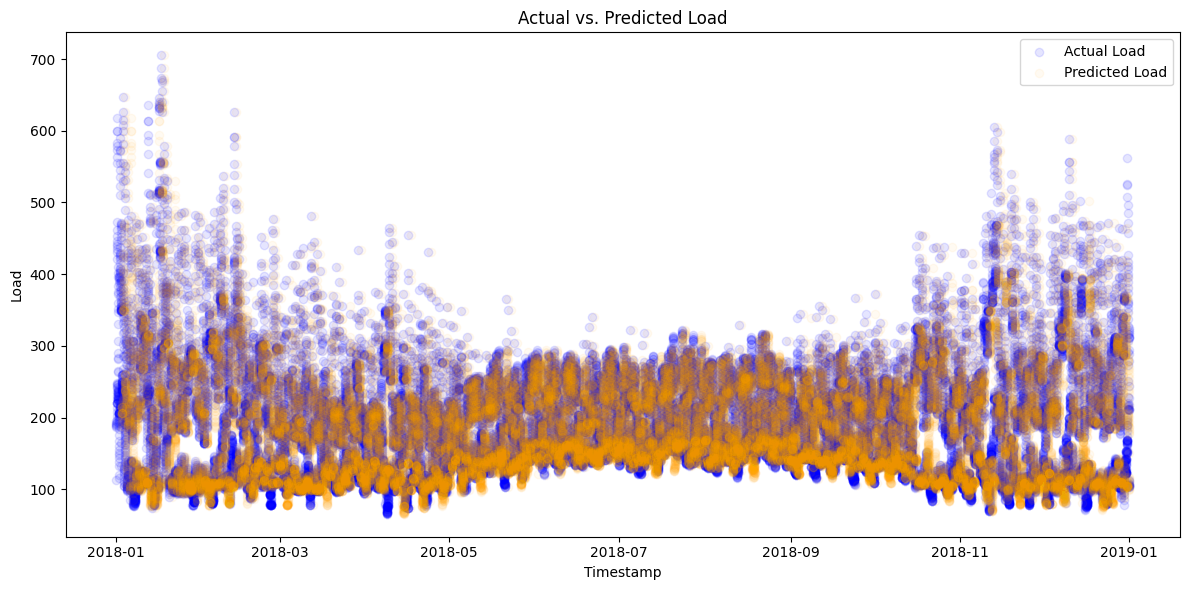

In [26]:
def plot_actual_vs_predicted(Y_sample, sample_prediction):
    plt.figure(figsize=(12, 6))
    
    # Plot actual load
    plt.scatter(Y_sample.index, Y_sample['load'], label="Actual Load", color='blue', alpha=0.1)
    
    # Plot predicted load
    plt.scatter(sample_prediction.index, sample_prediction['load'], label="Predicted Load", color='orange', alpha=0.05)
    
    # Formatting the plot
    plt.xlabel('Timestamp')
    plt.ylabel('Load')
    plt.title('Actual vs. Predicted Load')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

# Run the plotting function
plot_actual_vs_predicted(Y_sample, sample_prediction)

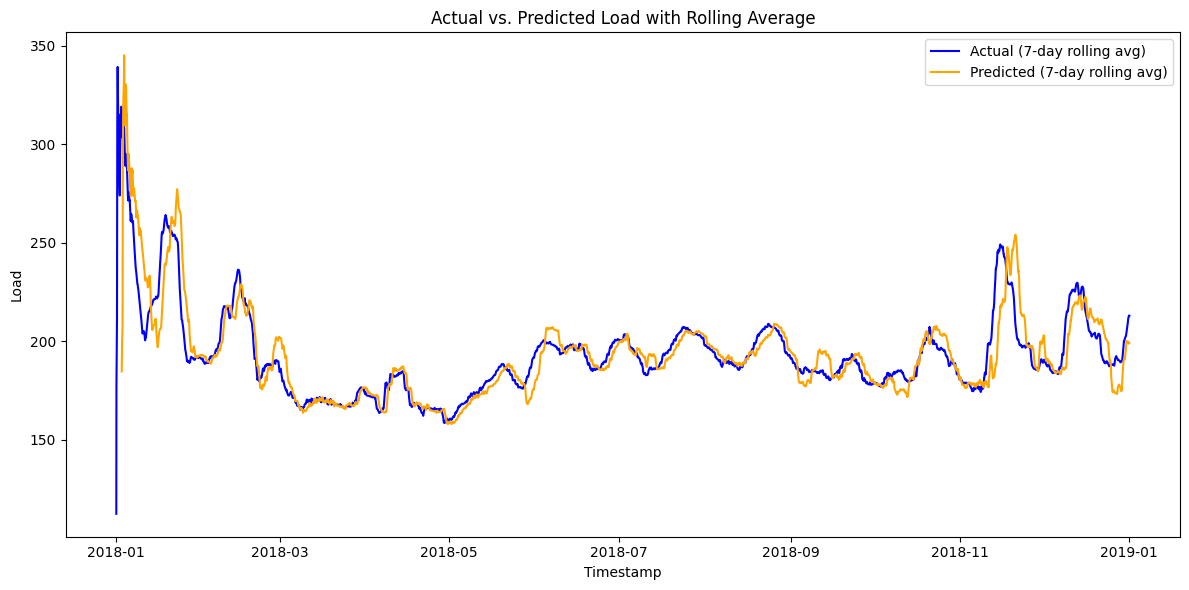

In [27]:
def plot_actual_vs_predicted_rolling(Y_sample, sample_prediction):
    plt.figure(figsize=(12, 6))
    
    # Compute rolling averages
    Y_sample['Actual_Rolling'] = Y_sample['load'].rolling(window=96*7, min_periods=1).mean()
    sample_prediction['Predicted_Rolling'] = sample_prediction['load'].rolling(window=96*7, min_periods=1).mean()
    
    # Plot rolling averages
    plt.plot(Y_sample.index, Y_sample['Actual_Rolling'], label="Actual (7-day rolling avg)", color='blue')
    plt.plot(sample_prediction.index, sample_prediction['Predicted_Rolling'], label="Predicted (7-day rolling avg)", color='orange')
    
    # Formatting the plot
    plt.xlabel('Timestamp')
    plt.ylabel('Load')
    plt.title('Actual vs. Predicted Load with Rolling Average')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

# Run the plotting function
plot_actual_vs_predicted_rolling(Y_sample, sample_prediction)

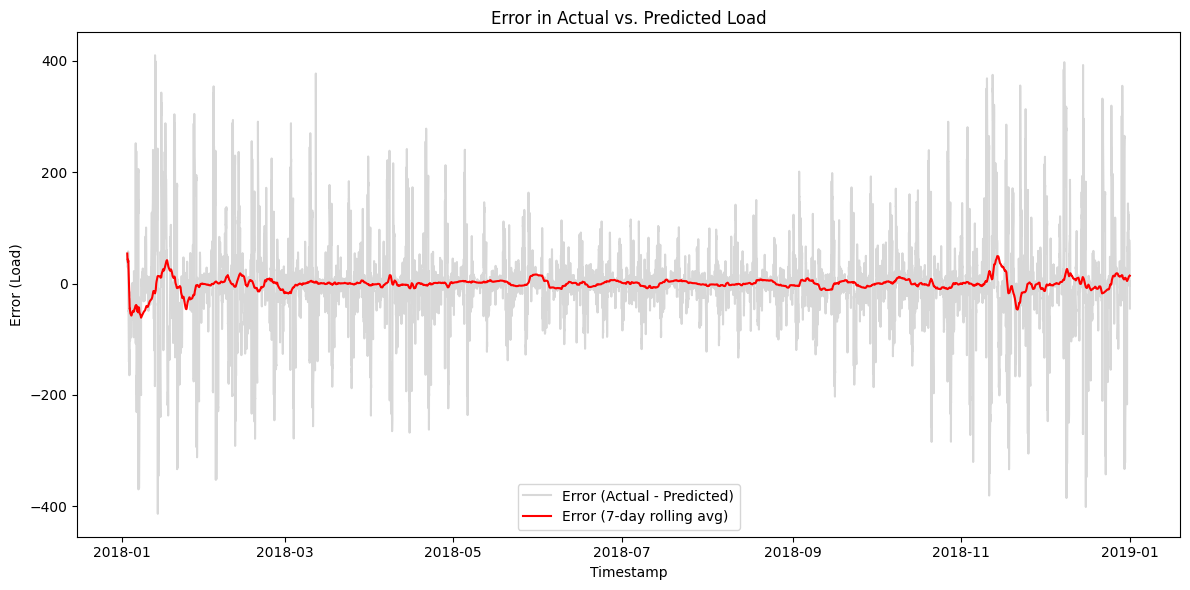

In [28]:
def plot_error(Y_sample, sample_prediction):
    plt.figure(figsize=(12, 6))
    
    # Compute the error (difference)
    error = Y_sample['load'] - sample_prediction['load']
    error_rolling = error.rolling(window=96*7, min_periods=1).mean()
    
    # Plot the error and rolling average of the error
    plt.plot(Y_sample.index, error, label="Error (Actual - Predicted)", color='gray', alpha=0.3)
    plt.plot(Y_sample.index, error_rolling, label="Error (7-day rolling avg)", color='red')
    
    # Formatting the plot
    plt.xlabel('Timestamp')
    plt.ylabel('Error (Load)')
    plt.title('Error in Actual vs. Predicted Load')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

# Run the plotting function
plot_error(Y_sample, sample_prediction)


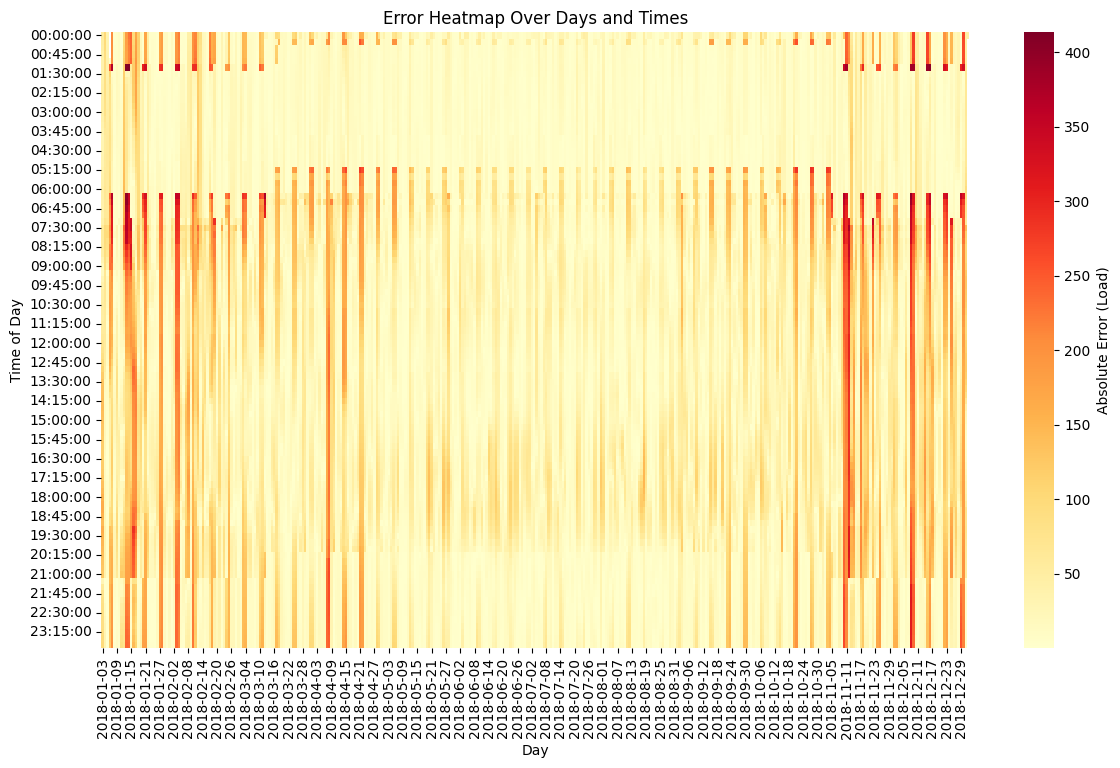

In [29]:
import seaborn as sns

def plot_error_heatmap(Y_sample, sample_prediction):
    # Compute absolute error
    Y_sample['error'] = np.abs(Y_sample['load'] - sample_prediction['load'])
    
    # Extract day and time from the index
    Y_sample['day'] = Y_sample.index.date
    Y_sample['time'] = Y_sample.index.time
    
    # Pivot table for heatmap
    heatmap_data = Y_sample.pivot_table(values='error', index='time', columns='day')
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, cmap="YlOrRd", cbar_kws={'label': 'Absolute Error (Load)'})
    plt.title("Error Heatmap Over Days and Times")
    plt.xlabel("Day")
    plt.ylabel("Time of Day")
    plt.show()

# Run the plotting function
plot_error_heatmap(Y_sample, sample_prediction)
